**Dataset Loading**

In [2]:
#Importing the necessary Libraries
import zipfile
import os

# This is the ZIP path of our dataset
zip_path = 'IMdB_dataset.zip'

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Checking the contents of the extracted files
print("Files in the dataset folder:", os.listdir('/content/train'))

Files in the dataset folder: ['pos', 'urls_pos.txt', 'neg', 'urls_unsup.txt', 'urls_neg.txt', 'labeledBow.feat', 'unsup', 'unsupBow.feat']


**Data Acquisiton**






In [3]:
# Specifying the path of training positive & negative reviews
train_pos_dir = '/content/train/pos/'
train_neg_dir = '/content/train/neg/'

#Defining a function to load the reviews from the Directory
def load_reviews(directory):
    reviews = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                reviews.append(file.read())
    return reviews

# Loading positive and negative reviews
train_pos_reviews = load_reviews(train_pos_dir)
train_neg_reviews = load_reviews(train_neg_dir)

# Printing the number of reviews loaded
print(f"Loaded {len(train_pos_reviews)} positive training reviews.")
print(f"Loaded {len(train_neg_reviews)} negative training reviews.")

Loaded 12500 positive training reviews.
Loaded 12500 negative training reviews.


**Data Pre-processing**

In [4]:
# Import all the necessary libraries (specified below)
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Converts the list of stop words into a Python set
stop_words = set(stopwords.words('english'))

# Initialize WordNet Lemmatizer (Reduces word to their base form)
lemmatizer = WordNetLemmatizer()

# Function for text preprocessing
def preprocess_text(text):
  #  Convert Short forms to their full form (e.g., “don’t” becomes “do not”)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'m", " am", text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove non-alphabet characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()

    # Tokenize text into words
    words = text.split()

    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join words back into a single string
    return ' '.join(words)

# Apply text preprocessing to the reviews
train_pos_reviews = [preprocess_text(review) for review in train_pos_reviews]
train_neg_reviews = [preprocess_text(review) for review in train_neg_reviews]

# print a sample preprocessed review
print("Sample preprocessed positive review:", train_pos_reviews[0])
print("Sample preprocessed negative review:", train_neg_reviews[0])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Sample preprocessed positive review: first saw film year ago ny television thought depressing look future well see restriction private freedom good thing private airplane year plus war film reason film shown british film goer war concept future korda co concept machine future real star film best acting performance ralph richardson bos combination winston churchill edina absolutely fabulous comedy series interesting note bos negative personality somewhat similar war time churchill
Sample preprocessed negative review: welcome bad ghost story someone nightmare horror tale find newly married husbandjohn hudsonand wifepeggy weberhaunted memory previous wife screaming skull found throughout empty mansion lily pond husband really trying drive already anxious bride insane learning challenged gardener mickeyalex nicolwho taken care mansion ground since death original mistress house low budget horror flick story line keep involved way finale special effect pretty bad even standard swear time scr

**Model 1 Support Vector Machine**

In [6]:
# Import necessary libraries for SVM and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Combine positive and negative reviews into one list and create labels
# (1 for positive reviews and 0 for negative reviews)
#reviews = train_pos_reviews + train_neg_reviews
labels = [1] * len(train_pos_reviews) + [0] * len(train_neg_reviews)  # 1 for positive, 0 for negative

# Converts text data into numerical form using Tf-idf
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(reviews)
y = labels

#Split Data into Training and Testing Sets, 80% for training 20% for testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Train the SVM model with training data
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train) #Understanding patterns of the data

#Test the model by making Predictions on test data
y_pred = svm_model.predict(X_val) #Predict labels
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred) #Details of the performance metrics

# Output the results
print("Accuracy of SVM:", accuracy) #Overall accuracy
print("Confusion Matrix:\n", conf_matrix) #Confusion matrix
print("Classification Report:\n", report)#Detailed performance stats

Accuracy of SVM: 0.876
Confusion Matrix:
 [[2142  343]
 [ 277 2238]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87      2485
           1       0.87      0.89      0.88      2515

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



**Model 2 Naives Bayes**

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Set up the Naïve Bayes model
nb_model = MultinomialNB() #Create a Naïve Bayes classifier

#Train the model with the training data
nb_model.fit(X_train, y_train) #Teach the model to recognize patterns in the data

#Test the model by making predictions on the test data
y_pred_nb = nb_model.predict(X_val) #Predict the labels for the test data

#Check how well the model performed
nb_accuracy = accuracy_score(y_val, y_pred_nb) #Calculate how accurate the predictions are
nb_conf_matrix = confusion_matrix(y_val, y_pred_nb) #Create a table showing true/false predictions
nb_report = classification_report(y_val, y_pred_nb) #Generate a detailed performance summary

# Output the results
print("Accuracy of Naïve Bayes:", nb_accuracy) #Overall Accuracy
print("Confusion Matrix:\n", nb_conf_matrix) # Confusion Matrix
print("Classification Report:\n", nb_report) # Detailed Performance stats

Accuracy of Naïve Bayes: 0.8464
Confusion Matrix:
 [[2062  423]
 [ 345 2170]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      2485
           1       0.84      0.86      0.85      2515

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



**Model 3 Random Forest**

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Set up the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42) #100 trees for this model

#Train the model with training data
rf_model.fit(X_train, y_train) #Teach the model to identify patterns

#Test the model by making predictions on the test data
y_pred_rf = rf_model.predict(X_val) #Predict the labels or the test data

#Check how well the model performed
rf_accuracy = accuracy_score(y_val, y_pred_rf) #Calculate accuracy
rf_conf_matrix = confusion_matrix(y_val, y_pred_rf) #Table showing true/false predictions
rf_report = classification_report(y_val, y_pred_rf) #Performance summary

# Output the results
print("Accuracy of Random Forest:", rf_accuracy) #Overall Accuracy
print("Confusion Matrix:\n", rf_conf_matrix) #Confusion matrix
print("Classification Report:\n", rf_report) #Detailed performance stats

Accuracy of Random Forest: 0.8362
Confusion Matrix:
 [[2102  383]
 [ 436 2079]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      2485
           1       0.84      0.83      0.84      2515

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



**Model 4 Gradient Boosting Classifier**

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1: Set up the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
# The model use 100 boosting stages (trees) and a learning rate of 0.1 to

# Step 2: Train the model with the training data
gb_model.fit(X_train, y_train)  # Train the model to ridentify patterns

# Step 3: Test the model by making predictions on the test data
y_pred_gb = gb_model.predict(X_val)  # Predict the labels for the test data

# Step 4: Check how well the model performed
gb_accuracy = accuracy_score(y_val, y_pred_gb)  # Measure the accuracy of the predictions
gb_conf_matrix = confusion_matrix(y_val, y_pred_gb)  # Table showing true/false predictions
gb_report = classification_report(y_val, y_pred_gb) #detailed performance summary

# Show the results
print("Accuracy of Gradient Boosting:", gb_accuracy)  # Accuracy
print("Confusion Matrix:\n", gb_conf_matrix)  # confusion matrix
print("Classification Report:\n", gb_report)  # detailed performance stats

Accuracy of Gradient Boosting: 0.8046
Confusion Matrix:
 [[1855  630]
 [ 347 2168]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.75      0.79      2485
           1       0.77      0.86      0.82      2515

    accuracy                           0.80      5000
   macro avg       0.81      0.80      0.80      5000
weighted avg       0.81      0.80      0.80      5000



**Model 5 Logistic Regression**

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1: Set up the Logistic Regression model
# Using 'liblinear' solver, which is good for small to medium-sized datasets
logistic_model = LogisticRegression(solver='liblinear', random_state=42)

# Step 2: Train the model with the training data
logistic_model.fit(X_train, y_train)  # Teach the model to identify patterns

# Step 3: Test the model by making predictions on the test data
y_pred_logistic = logistic_model.predict(X_val)  # Predict the labels

# Step 4: Check how well the model performed
logistic_accuracy = accuracy_score(y_val, y_pred_logistic)  # Measure how accurate the predictions are
logistic_conf_matrix = confusion_matrix(y_val, y_pred_logistic)  # Create a table showing true/false predictions
logistic_report = classification_report(y_val, y_pred_logistic)  # Generate a detailed performance summary

# Show the results
print("Accuracy of Logistic Regression:", logistic_accuracy)  # Accuracy
print("Confusion Matrix:\n", logistic_conf_matrix)  # confusion matrix
print("Classification Report:\n", logistic_report)  # Detailed performance stats

Accuracy of Logistic Regression: 0.8748
Confusion Matrix:
 [[2127  358]
 [ 268 2247]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87      2485
           1       0.86      0.89      0.88      2515

    accuracy                           0.87      5000
   macro avg       0.88      0.87      0.87      5000
weighted avg       0.88      0.87      0.87      5000



**Comparing all the models**

In [16]:
import pandas as pd

# Constructing DataFrame for all the metrics for evaluation
data = {
    "Model": ["SVM", "Naïve Bayes", "Random Forest", "Gradient Boosting", "Logistic Regression"],
    "Accuracy": [0.876, 0.8464, 0.8362, 0.8046, 0.8748],
    "Precision_Class_0": [0.89, 0.86, 0.83, 0.84, 0.89],
    "Precision_Class_1": [0.87, 0.84, 0.84, 0.77, 0.86],
    "Recall_Class_0": [0.86, 0.83, 0.85, 0.75, 0.86],
    "Recall_Class_1": [0.89, 0.86, 0.83, 0.86, 0.89],
    "F1_Score_Class_0": [0.87, 0.84, 0.84, 0.79, 0.87],
    "F1_Score_Class_1": [0.88, 0.85, 0.84, 0.82, 0.88]
}

df = pd.DataFrame(data)
print(df)

                 Model  Accuracy  Precision_Class_0  Precision_Class_1  \
0                  SVM    0.8760               0.89               0.87   
1          Naïve Bayes    0.8464               0.86               0.84   
2        Random Forest    0.8362               0.83               0.84   
3    Gradient Boosting    0.8046               0.84               0.77   
4  Logistic Regression    0.8748               0.89               0.86   

   Recall_Class_0  Recall_Class_1  F1_Score_Class_0  F1_Score_Class_1  
0            0.86            0.89              0.87              0.88  
1            0.83            0.86              0.84              0.85  
2            0.85            0.83              0.84              0.84  
3            0.75            0.86              0.79              0.82  
4            0.86            0.89              0.87              0.88  


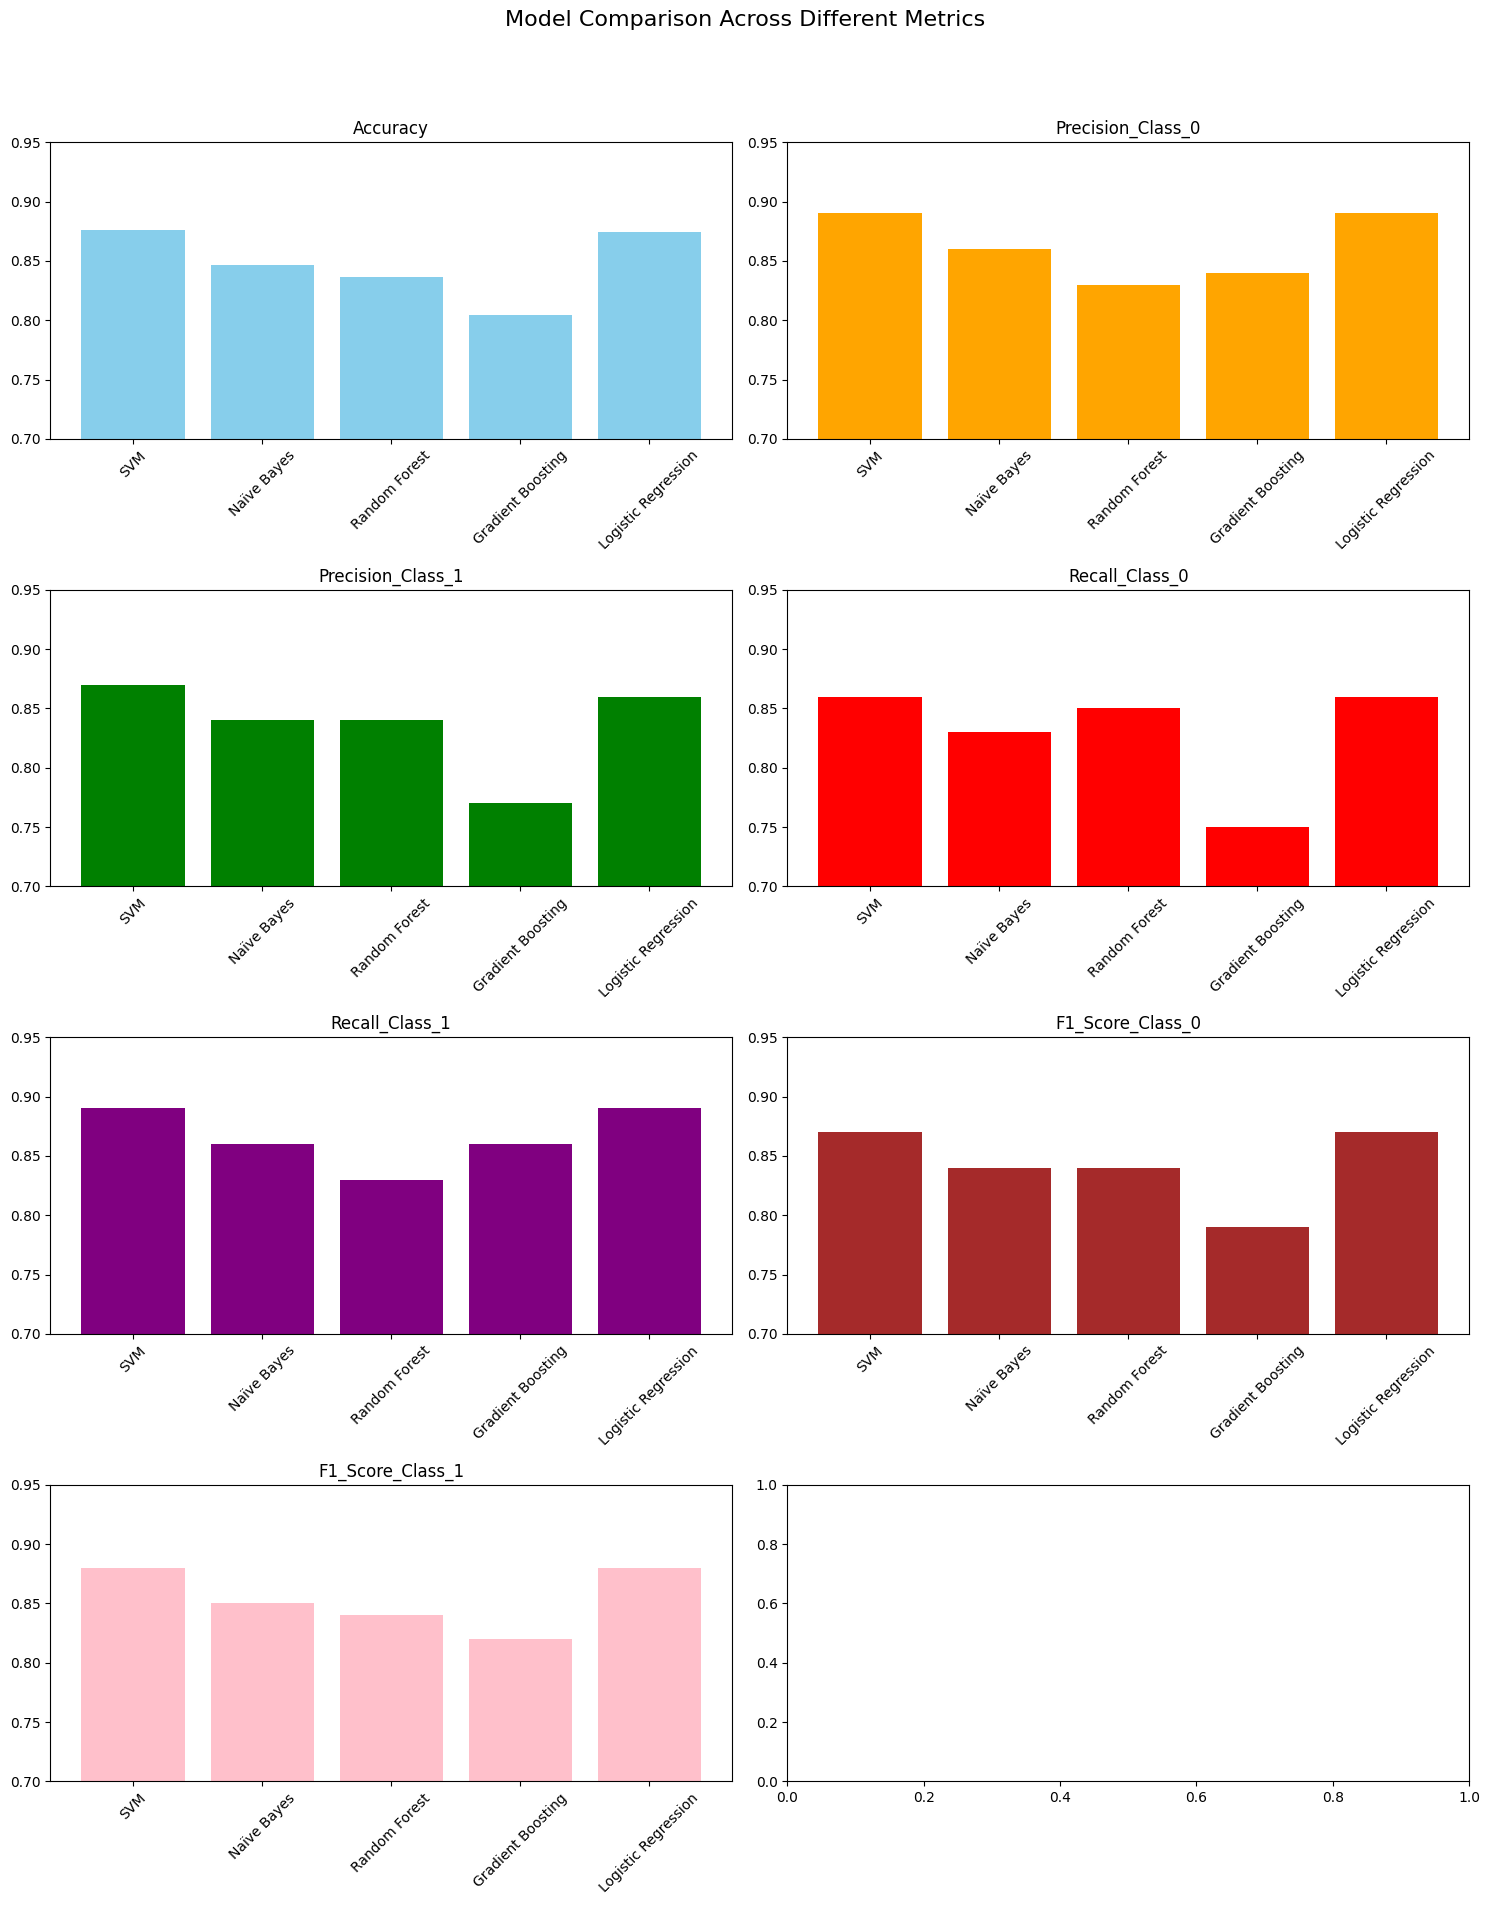

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# DataFrame setup
data = {
    "Model": ["SVM", "Naïve Bayes", "Random Forest", "Gradient Boosting", "Logistic Regression"],
    "Accuracy": [0.876, 0.8464, 0.8362, 0.8046, 0.8748],
    "Precision_Class_0": [0.89, 0.86, 0.83, 0.84, 0.89],
    "Precision_Class_1": [0.87, 0.84, 0.84, 0.77, 0.86],
    "Recall_Class_0": [0.86, 0.83, 0.85, 0.75, 0.86],
    "Recall_Class_1": [0.89, 0.86, 0.83, 0.86, 0.89],
    "F1_Score_Class_0": [0.87, 0.84, 0.84, 0.79, 0.87],
    "F1_Score_Class_1": [0.88, 0.85, 0.84, 0.82, 0.88]
}

df = pd.DataFrame(data)

# Plotting
metrics = ['Accuracy', 'Precision_Class_0', 'Precision_Class_1', 'Recall_Class_0', 'Recall_Class_1', 'F1_Score_Class_0', 'F1_Score_Class_1']
colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Model Comparison Across Different Metrics', fontsize=16)

for i, metric in enumerate(metrics):
    ax = plt.subplot(4, 2, i + 1)
    ax.bar(df['Model'], df[metric], color=colors[i % len(colors)])
    ax.set_title(metric)
    ax.set_ylim([0.7, 0.95])
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()